# Figure 3: PANDA analysis of fibrin

This notebook applies PANDA to a fibrin sample. It generates figures for several intermediate steps, culminating in Figure 3. All of the core scientific logic is imported from `photoactivation.py`.

Updated 2015-11-23

## Unresolved Differences from Figure 2

* Subtraction of stuck map must be done as int
* Profiles must be shifted by a constant so that their min = 0.
* "Rainbow plot" should have `bound=True` (this is actually an OK discrepency, IMO)

## Overview

1. Import packages; load data and metadata.
2. Compute profiles, and subtract the intensity due to stuck particles.
3. Map each profile onto a future profile by convolving with a Gaussian.
4. Choose a representative value of $\sigma$ for each lag time $t$. Plot $\sigma(t)$.
5. Draw the final figure.


## Step 1: Import packages; load data and metadata.

All of the dependencies are given in the `environment.yml` file in this repository.

In [1]:
%matplotlib notebook

import os
from itertools import cycle
from collections import OrderedDict

import yaml
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pims

import photoactivation as pa  # importing from photoactivation.py in the working directory

/Users/dallan/miniconda/envs/pa/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Use Bob's plot style preferences
# mpl.style.use('https://tiny.cc/leheny-style/raw')

In [3]:
calibrations = yaml.load(open('calibrations.yml'))

In [4]:
filename = "20140520 JCK20140519 10fold in fibrin 4mg_mL PLGA-PEG-Rhod Activation_20x 3.93sec 10 iterations 4 AU 1.lsm"
filepath = os.path.join("data", filename)
objective = '20X'
exposure_time = 3.930  # s
first_illuminated_frame = 5
mpp = calibrations[objective]

In [5]:
# A pims.pipeline is a function that only gets evaluated at the last moment.

@pims.pipeline
def grayscale(img):
    return np.sum(img, 0)
    
v = grayscale(pims.open(filepath))

In [6]:
v

Sliced and/or processed TiffStack_tifffile. Original repr:
    <Frames>
    Source: data/20140520 JCK20140519 10fold in fibrin 4mg_mL PLGA-PEG-Rhod Activation_20x 3.93sec 10 iterations 4 AU 1.lsm
    Length: 500 frames
    Frame Shape: (3, 512, 512)
    Pixel Datatype: H

In [7]:
v[10].mean()

7714.9440422058105

<IPython.core.display.Javascript object>


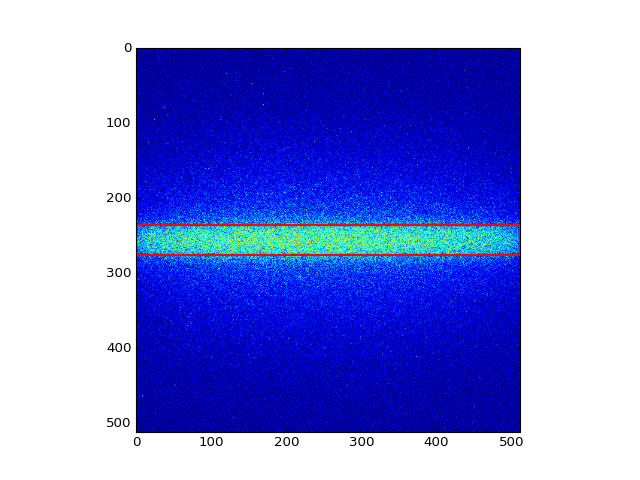

In [8]:
pa.outline_activation_region(v[7])

## Step 2: Compute profiles, and subtract the intensity due to stuck particles.

We define a function that sums along an axis, subtracts a constant background, and caches the result for fast repeated computations.

In [9]:
help(pa.make_profiler)

Help on function make_profiler in module photoactivation:

make_profiler(background, axis)
    Build a function that subtracts the background and sums along an axis
    
    Parameters
    ----------
    background : number
        intensity to subtract from the profile
    axis : int
        which axis to sum along
        
    Returns
    -------
    func :
        function with the signature (img_stack, i)



<IPython.core.display.Javascript object>


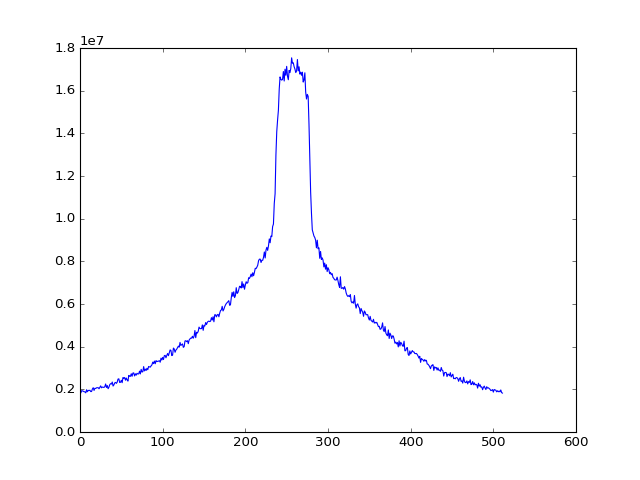

In [10]:
# Later, we'll make a new profiler that employs more complicated background subtraction.
flat_background = v[0].shape[1] * np.mean(v[first_illuminated_frame - 1])
raw_profiler = pa.make_profiler(0, 1)
simple_profiler = pa.make_profiler(flat_background, 1)

# Plot the profile for the last frame in the video.
plt.figure()
plt.plot(raw_profiler(v, -1))

The activation region contains many particles that do not appear to be diffusing outward. We can estimate how much of the intensity in the activation region is due to stuck particles by fitting a Gaussian to the tails of the distribution only and then extrapolating it through the center.

<IPython.core.display.Javascript object>


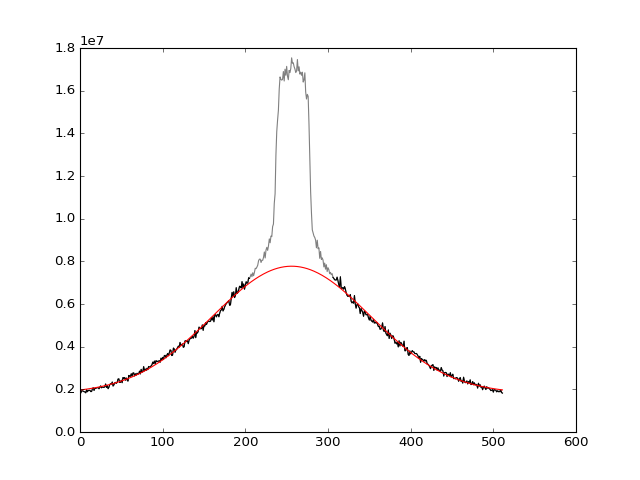

In [11]:
last_profile = raw_profiler(v, -1)

guess = {'sigma': 50, 'amplitude': 1e7, 'c':0.3e7, 'center': 300}
fit_result = pa.fit_profile_tails(last_profile, guess, halfwidth=50)

pa.plot_tail_fit(last_profile, fit_result, halfwidth=50)

In [12]:
fit_result.best_values

{'amplitude': 1431938860.535301,
 'c': 1801773.5157889829,
 'center': 255.99276280624798,
 'sigma': 95.690405542998121}

By subtracting the red curve from image, we obtain a rough "map" of the intensity due to stuck particles.

<IPython.core.display.Javascript object>


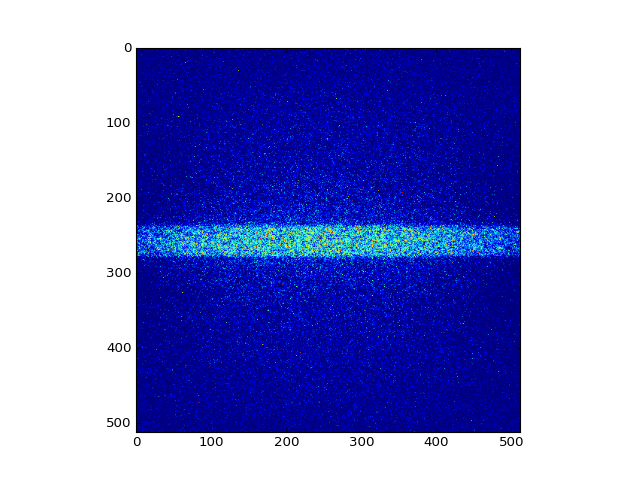

In [12]:
extrapolated = pa.extrapolate_fit(fit_result, np.arange(512))
gaussian_as_image = pa.line_as_image(extrapolated, 512)
stuck_map = np.clip(np.asarray(v[-1], np.float64) - gaussian_as_image, 0, None)
# stuck_map = pa.subtract_safely(v[-1], gaussian_as_image)

plt.figure()
plt.imshow(stuck_map)

In [14]:
def subtract_frames(frame1, frame2):
    """There is some subtlety here -- you can't just frame1 - frame2 --
    but we'll contain the technical details in this function."""
    return np.clip(frame1.astype('int16') - frame2.astype('int16'), 0, None)

old_stuck_map = subtract_frames(v[-1], gaussian_as_image)
np.mean(old_stuck_map), np.max(old_stuck_map), np.min(old_stuck_map)

(2787.8842887878418, 32766, 0)

In [15]:
reduced_frames = [subtract_frames(frame, old_stuck_map) - v[4].mean() for frame in v]

In [16]:
def profiler(_, i):
    return reduced_frames[i].sum(1)

Now we'll make a new profile-generating function that subtracts this image of stuck particles from every frame.

In [17]:
# profiler = pa.make_profiler(stuck_map + mean_background, 1)

<IPython.core.display.Javascript object>


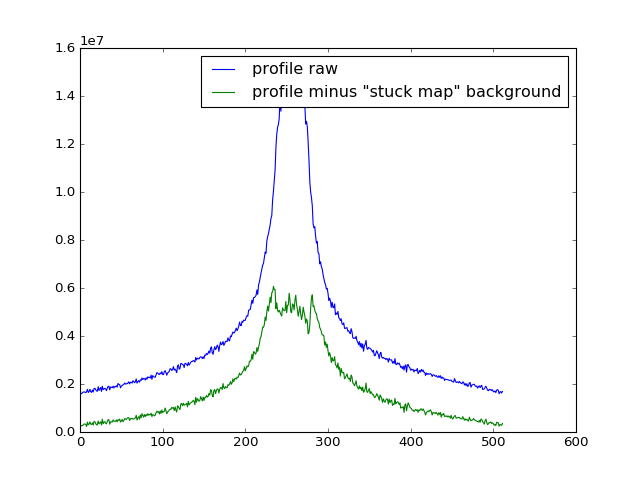

In [18]:
plt.figure()
plt.plot(raw_profiler(v, 15), label='profile raw')
plt.plot(profiler(v, 15), label='profile minus "stuck map" background')
plt.legend()

## Step 3: Map each profile onto a future profile by convolving with a Gaussian.

Use a nonlinear-least-squared fit to determine the Gaussian kernel that best maps a given profile onto another profile.

To start, we'll map each profile onto the profile 40 frames in the future. We'll extract $\sigma$ from the best fit, and plot it.

In [19]:
help(pa.fit_profiles_recursively)

Help on function fit_profiles_recursively in module photoactivation:

fit_profiles_recursively(profiles, lag, *, recursive=True, bound=False, reverse=False)
    Parameters
    ----------
    profiles: list
        profiles evenly spaced in time
    lag : int
        profiles to skip
    recursive : bool, optional
        If True, use last fit as initial guess for current fit.
        True by default.
    bound : bool, optional
        If True, apply min/max bounds to the fit.
        False by default.
    reverse : bool, option
        If True, start at the end of the video and work backward.
        This affects the seeding of the fits (initial guesses are
        passed backward instead of forward).
        
    Returns
    -------
    results : list
        list of lmfit Result objects



<IPython.core.display.Javascript object>


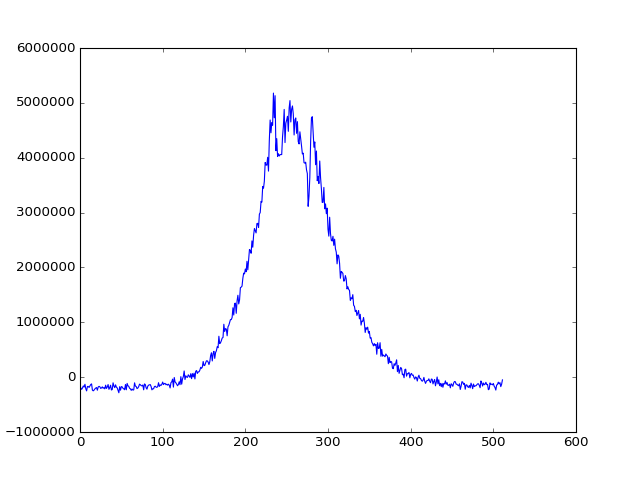

In [20]:
plt.figure()
plt.plot(profiler(v, 5))

In [21]:
profiles = [profiler(v, i) - profiler(v, i).min() for i in range(first_illuminated_frame, len(v))]

# Note that, unlike in Figure 2, putting bounds on the parameters seems
# to improve the result of the fit.
fit_results = pa.fit_profiles_recursively(profiles, 10)
sigmas = [mpp * fit_result.values['sigma'] for fit_result in fit_results]

<IPython.core.display.Javascript object>


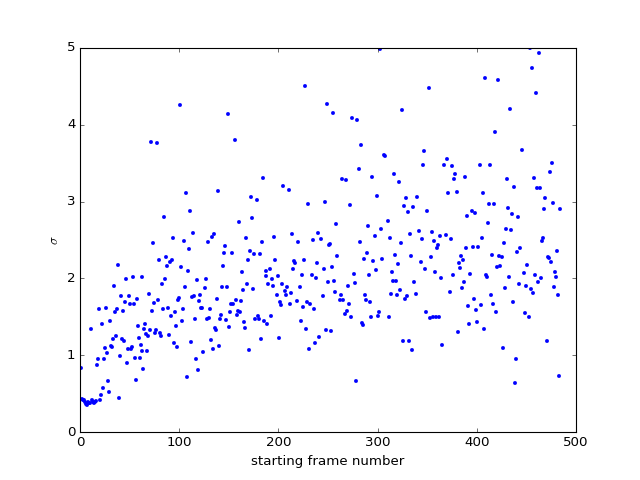

(0, 5)

In [22]:
plt.figure()
plt.plot(sigmas, '.')
plt.ylabel('$\sigma$')
plt.xlabel('starting frame number')
plt.ylim(0, 5)

We'll repeat this for several lag times.

In [23]:
lags = range(20, len(v), 20)  # e.g., 20, 40, ...
sigmas = OrderedDict()  # results buffer
for lag in lags:
    fit_results = pa.fit_profiles_recursively(profiles, lag, bound=True)
    sigmas[lag] = [mpp * fit_result.values['sigma'] for fit_result in fit_results]

<IPython.core.display.Javascript object>


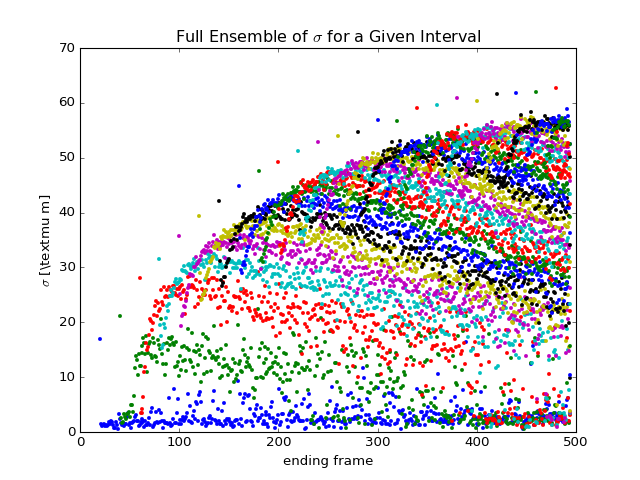

In [26]:
plt.figure()
# rainbow_colors = cycle([(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.9386807511529497, 0.48901639250529133, 0.19623149776413562), (0.775731904186273, 0.5784925270759935, 0.19475566538551872), (0.6566480096570136, 0.6229564921397143, 0.1938976562578914), (0.5105309046900421, 0.6614299289084904, 0.1930849118538962), (0.19468252393000074, 0.6998280342882891, 0.3041476695746048), (0.20433460114757862, 0.6863857739476534, 0.5407103379425205), (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), (0.21662978923073606, 0.6676586160122123, 0.7318695594345369), (0.2266813382629933, 0.6508721810235698, 0.85618939194681), (0.5049017849530067, 0.5909119231215284, 0.9584657252128558), (0.7563369715809057, 0.5008642633638004, 0.9580503362615219), (0.9587050080494405, 0.36622595657917456, 0.9231469575614251), (0.9640248692994725, 0.41206779951067346, 0.7303540600728443)])

for lag, s in sigmas.items():
    plt.plot(lag + np.arange(len(s)), s, '.', label=lag) #, color=next(rainbow_colors))
    
plt.gca().set(xlabel='ending frame', ylabel=r'$\sigma$ [\textmu m]')
# plt.gca().legend(loc='best', title='lag interval', fontsize=12)
plt.gca().set(title=r'Full Ensemble of $\sigma$ for a Given Interval')

There are evidently both random and systematic errors leading to some spread in the value of sigma at a given lag time as measured at different start and end times.

## Step 4: Choose a representative value of $\sigma$ for each lag time $t$. Plot $\sigma(t)$.

In [29]:
# Skip the first point. Take the mean of the remaining points.
representative_sigma = np.asarray([np.mean(s[15:]) for s in sigmas.values()])
lag_times = np.asarray(lags) * exposure_time

/Users/dallan/miniconda/envs/pa/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


<IPython.core.display.Javascript object>


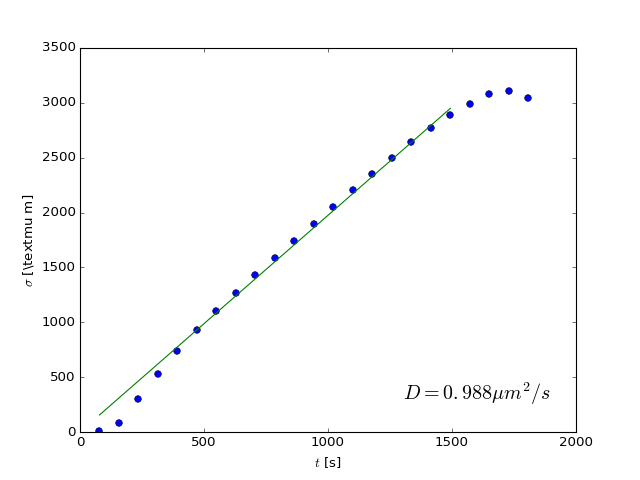

In [30]:
plt.figure()
plt.plot(lag_times, representative_sigma**2, 'o')
plt.ylabel(r'$\sigma$ [\textmu m]')
plt.xlabel(r'$t$ [s]')

In [31]:
slope, = pa.fit_line(lag_times[:-5], representative_sigma[:-5]**2).params
D = slope/2

# Update the plot above, adding a best-fit line and a text annotation.
plt.plot(lag_times[:-5], slope * lag_times[:-5])
plt.text(0.8, 0.1, r'$D={:.3} \mu m^2/s$'.format(D), size=18,
         ha='center', va='center', transform=plt.gca().transAxes)

## Step 5: Draw the final figure

Dense matplotlib code lays out a grid of subfigures just the way we want them.

In [ ]:
plt.figure(figsize=(12, 6))

# Construct a grid of subplots.
grid = mpl.gridspec.GridSpec(4, 4, width_ratios=[1, 3, 2, 2])
image_axes = list(map(plt.subplot, [grid[i, 0] for i in range(4)]))
profile_axes = list(map(plt.subplot, [grid[i, 1] for i in range(4)]))
plot_ax = plt.subplot(grid[:, 2:])

# Configure axes labels / ticks.
[ax.set(xticks=[], yticks=[]) for ax in image_axes]
[ax.set(xticks=[], yticks=[], ylabel='intensity') for ax in profile_axes]
profile_axes[-1].set(xlabel='position')
image_axes[-1].set(xlabel='position')
plot_ax.set(xlabel=r'$t$ [s]', ylabel=r'$\sigma^2$ [\textmu m$^2$]')

# Draw in the frames of video.
frame_nos = [6, 81, 150, 210]  # Ben chose [6, 81, 196, 387] but I'm missing 387 -- fix later!
for ax, frame_no in zip(image_axes, frame_nos):
    image = v[frame_no]
    # flip diagonally
    image = image.T
    ax.imshow(image)

# Draw in the profiles.
PROFILE_WINDOW_HEIGHT = 2e7
for ax, frame_no in zip(profile_axes, frame_nos):
    ax.plot(profiles[frame_no - first_illuminated_frame], 'k')
    ax.set(ylim=(0, PROFILE_WINDOW_HEIGHT))
    # Label the time
    t = int(round((frame_no - first_illuminated_frame) * exposure_time, 0))
    ax.text(0.9, 0.6, '{0} s'.format(t), ha='right', va='center', transform=ax.transAxes)
    
# Outline the activation region.
rectangle1 = mpl.patches.Rectangle((512//2 - 20, 0), 40, 511,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=image_axes[0].transData)
rectangle2 = mpl.patches.Rectangle((512//2 - 20, 0), 40, PROFILE_WINDOW_HEIGHT,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=profile_axes[0].transData)
image_axes[0].add_patch(rectangle1)
profile_axes[0].add_patch(rectangle2)
    
# Draw in the sigma vs. t data.
plot_ax.plot(lag_times, representative_sigma**2, 'ko')
plot_ax.plot(lag_times, slope * lag_times, 'k-')
# plot_ax.set(yticks=[0, 500, 1000, 1500, 2000])

# Label (a), (b), (c).
image_axes[0].text(0.2, 0.6, '(a)', ha='center', va='center', transform=image_axes[0].transAxes, color='white')
profile_axes[0].text(0.1, 0.6, '(b)', ha='center', va='center', transform=profile_axes[0].transAxes)
plot_ax.text(0.1, 0.9, '(c)', ha='center', va='center', transform=plot_ax.transAxes)

# Tweak subplot spacing.
# plot_ax.figure.set_size_inches(14.5, 7)
grid.tight_layout(plot_ax.figure, h_pad=0.3, w_pad=0.5)
